In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
# Import system helpers
import os
import pathlib

# Import TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Import helper libraries
import numpy as np
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
import IPython.display as display
from PIL import Image

In [3]:
# Convert .mat to Python dict with Scipy.io

sc_devkit = '/Users/katerina/Workspace/visual_census/data/devkit'

cars_meta = scipy.io.loadmat(os.path.join(sc_devkit, 'cars_meta.mat'))['class_names']
cars_train_annos = scipy.io.loadmat(os.path.join(sc_devkit, 'cars_train_annos.mat'))['annotations']

In [4]:
# Extract Car Metadata from dictionary to an array

car_makes = []
for idx, vehicle in enumerate(cars_meta[0]):
    car_makes.append([vehicle[0],vehicle[0].split(' ')[0], vehicle[0].split(' ')[-1]])
car_makes = pd.DataFrame(car_makes, columns=['full_label', 'mnfr', 'year'])

In [5]:
# Extract Car Labels from dictionary to a list
# List used because both int (label) and str (img id) required

cars_train_labels = []
cars_train_annotations = []
for idx, anno in enumerate(cars_train_annos[0]):
    cars_train_labels.append([anno[4][0][0], anno[5][0]])
    cars_train_annotations.append([anno[0][0][0], anno[1][0][0], anno[2][0][0], anno[3][0][0], anno[4][0][0], anno[5][0]])
cars_train_annotations = pd.DataFrame(cars_train_annotations, columns=['bb0', 'bb1', 'bb2', 'bb3', 'label', 'img_name'])

In [6]:
sc_cars_train = '/Users/katerina/Workspace/visual_census/data/cars_train'
train_data_dir = pathlib.Path(sc_cars_train)

In [7]:
train_image_count = len(list(train_data_dir.glob('*.jpg')))

In [9]:
train_image_names = np.array([item.name for item in train_data_dir.glob('*')])
train_image_names

array(['04354.jpg', '02725.jpg', '07885.jpg', ..., '01235.jpg',
       '05053.jpg', '03422.jpg'], dtype='<U9')

In [10]:
car_makes.iloc[14]

full_label    Audi R8 Coupe 2012
mnfr                        Audi
year                        2012
Name: 14, dtype: object

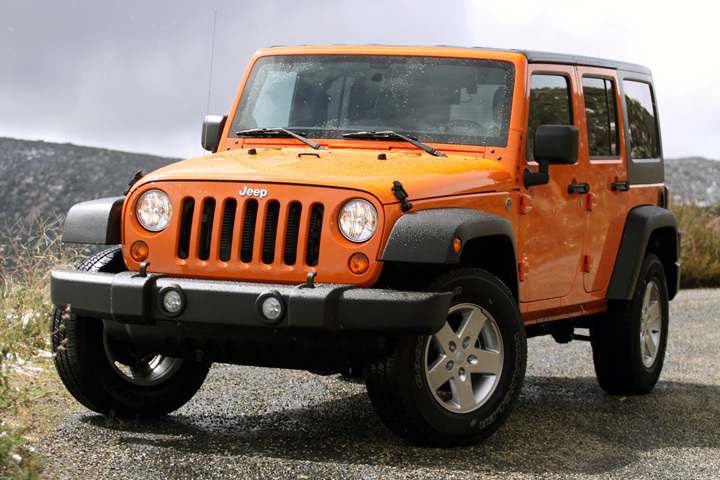

In [11]:
for image_path in train_image_names[:1]:
    display.display(Image.open(os.path.join(sc_cars_train,image_path)))